In [28]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time


from torch.optim import Optimizer

In [2]:
# hyper parameters

input_size = 64*64
hidden_size = 100
batch_size = 192
learning_rate = 0.0005

# Loading Data

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            images.append(img.reshape(1,64*64))
    images = np.array(images)
    images = images.reshape(images.shape[0],64*64)/255
    return images

In [4]:
X_cats = load_images_from_folder("dataset_cats/cats/")
y_cats = np.ones((X_cats.shape[0],1))
X_noncats = load_images_from_folder("dataset_cats/non-cats/")
y_noncats = np.zeros((X_noncats.shape[0],1))

X_data = np.append(X_cats,X_noncats, axis=0)
y_data = np.append(y_cats,y_noncats, axis=0)


X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=9)

Xy_train = np.concatenate([X_train,y_train], axis=1)

y = [1.]


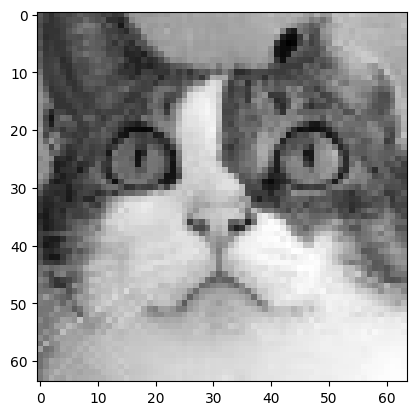

In [5]:
# Example of a picture
index = 0
plt.imshow(X_train[index,:].reshape((64,64)),cmap="gray")
print ("y = " + str(y_train[index]))

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=Xy_train, batch_size=192, shuffle=False)

# Model

In [7]:
class NeuralNet(nn.Module):
    def __init__(self,input_size,hidden_size):
        super(NeuralNet,self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size,1)
        self.sigmoid = nn.Sigmoid()

        
    def forward(self,x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.sigmoid(out)
        return out
    

# Adam

In [38]:
def evaluate():
    with torch.no_grad():
        outputs = model(torch.Tensor(X_test))
        acc = accuracy_score(y_test, outputs>0.5)
    print(f'accuracy = {acc}')
    return acc

In [39]:
model = NeuralNet(input_size,hidden_size)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [40]:
n_total_steps = len(train_loader)
losses_adam = []
iteration = 0
acc_adam = []

init_time = time.time()

num_epochs = 20
for epoch in range(num_epochs):
    for i, Xy_data in enumerate(train_loader):
        images = Xy_data[:,:-1].to(torch.float32)
        labels = Xy_data[:,-1].reshape(Xy_data.shape[0],1).to(torch.float32)

        
        # forward:
        outputs = model(images)
        loss = criterion(outputs,labels)
        if iteration == 0:
            print(f'Initial loss = {loss.item():.4f}\n\n')
        
        # backwards:
        optimizer.zero_grad()
        loss.backward(create_graph=True)
        optimizer.step()
        
        losses_adam.append([iteration,loss.item()])
        iteration += 1
        if (i+1) % 10 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1} / {n_total_steps}, loss = {loss.item():.4f}')
    acc_adam.append(evaluate())
    
elapsed = time.time() - init_time
print("elapsed time: " + str(elapsed))

Initial loss = 0.7015


epoch 1 / 20, step 10 / 10, loss = 0.6933
accuracy = 0.7020833333333333
epoch 2 / 20, step 10 / 10, loss = 0.5593
accuracy = 0.7
epoch 3 / 20, step 10 / 10, loss = 0.5233
accuracy = 0.7
epoch 4 / 20, step 10 / 10, loss = 0.5018
accuracy = 0.7375
epoch 5 / 20, step 10 / 10, loss = 0.4857
accuracy = 0.7791666666666667
epoch 6 / 20, step 10 / 10, loss = 0.4659
accuracy = 0.7875
epoch 7 / 20, step 10 / 10, loss = 0.4533
accuracy = 0.80625
epoch 8 / 20, step 10 / 10, loss = 0.4363
accuracy = 0.8104166666666667
epoch 9 / 20, step 10 / 10, loss = 0.4195
accuracy = 0.8125
epoch 10 / 20, step 10 / 10, loss = 0.4351
accuracy = 0.8291666666666667
epoch 11 / 20, step 10 / 10, loss = 0.3911
accuracy = 0.8291666666666667
epoch 12 / 20, step 10 / 10, loss = 0.3652
accuracy = 0.8395833333333333
epoch 13 / 20, step 10 / 10, loss = 0.3621
accuracy = 0.85
epoch 14 / 20, step 10 / 10, loss = 0.3654
accuracy = 0.8645833333333334
epoch 15 / 20, step 10 / 10, loss = 0.3646
accuracy = 

In [11]:
losses_arr_adam = np.array(losses_adam)

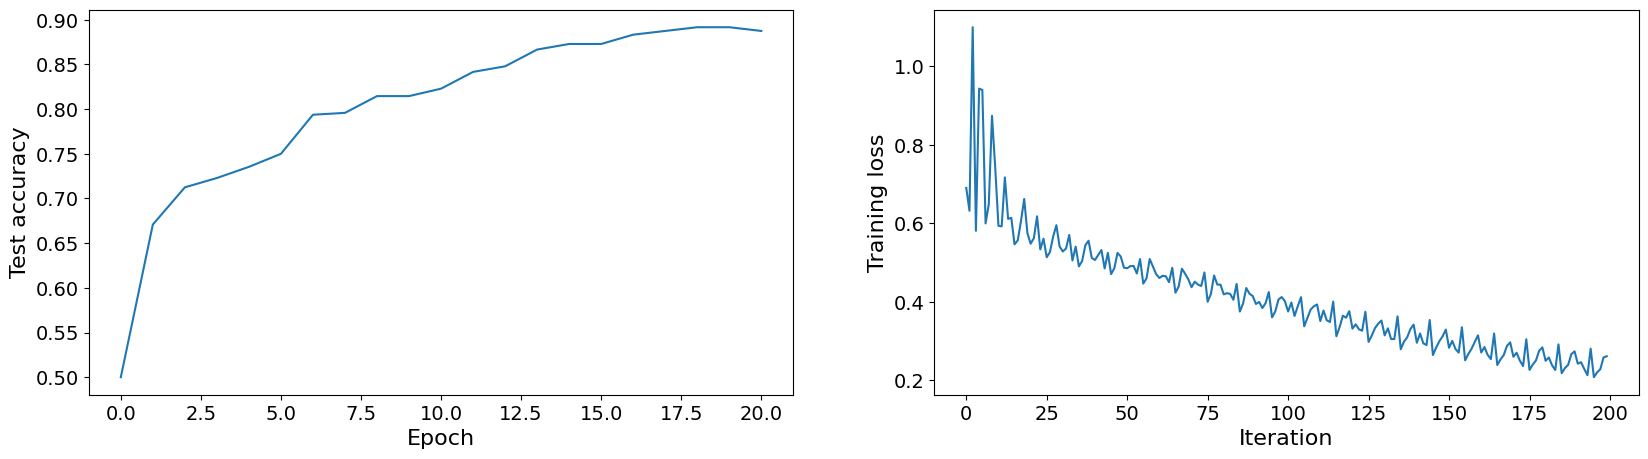

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

ax[0].plot(np.append(0.5,acc_adam))
ax[1].plot(losses_arr_adam[:,1])




ax[0].set_xlabel("Epoch",fontsize=16)
ax[0].set_ylabel("Test accuracy",fontsize=16)
ax[1].set_ylabel("Training loss",fontsize=16)
ax[1].set_xlabel("Iteration",fontsize=16)

ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 

plt.savefig('neuralNet.pdf')  


In [36]:
init_time = time.time()
y_pred = model(torch.Tensor(X_test))
elapsed = time.time() - init_time
print("elapsed time: " + str(elapsed))

elapsed time: 0.010315179824829102


In [18]:
torch.onnx.export(model, torch.Tensor(X_test), 'model.onnx', input_names=["Image Vector"], output_names=["Cat classification"])

In [20]:
max(acc_adam)

0.8916666666666667

In [25]:
acc_save = np.append(0.5,acc_adam)
np.save("acc_NN.npy", acc_save)
cost_save = losses_arr_adam[:,1]
np.save("cost_NN.npy", cost_save)